In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# 1) PCA
Para esse exercício, usaremos novamente dados das eleições municipais de 2000:

In [2]:
link = 'https://raw.githubusercontent.com/FLS-6497/datasets/main/aula7/eleicoes2000.csv'
dados = pd.read_csv(link, sep=';', decimal=",").drop(['cod_mun_ibge', 'nome_municipio'], axis=1)

## a) Criando uma pipeline
Com os dados, implemente uma pipeline de classificação que use PCA para reduzir o número de features nos dados. Seu objetivo será predizer qual partido governa dado município. Calcule alguma métrica de validação.


In [3]:
dados[['outros_partidos', 'pmdb_psdb_pfl']] = pd.get_dummies(dados.partido)
dados = pd.concat([
        dados, 
        pd.get_dummies(dados.uf)
        ], 
        axis=1
    )
dados = dados.drop(['uf', 'coligacao', 'partido', 'outros_partidos'], axis=1)

y = dados.pmdb_psdb_pfl
X = dados.loc[:, dados.columns != 'pmdb_psdb_pfl']

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('pca', PCA()), 
    ('svr', SVR())
    ])

pipe.fit(X_train, y_train)
mean_squared_error(y_test, pipe.predict(X_test), squared=False)

0.5315115841002184

In [4]:
pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('pca', PCA()), 
    ('ols', LinearRegression())
    ])

pipe.fit(X_train, y_train)
mean_squared_error(y_test, pipe.predict(X_test), squared=False)

17386918036.631535

## b) Testando diferentes pipelines
Partindo da pipeline anterior, crie diferentes pipelines alterando o número de dimensões no PCA para 2, 3, 4 e 5. Rode essas pipelines e compare seus resultados.

In [5]:
def testing_dim_pca(dim):
    
    pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('pca', PCA(n_components=dim)), 
    ('ols', LinearRegression())
    ])

    pipe.fit(X_train, y_train)
    return mean_squared_error(y_test, pipe.predict(X_test), squared=False)

dims = [2, 3, 4, 5]
[testing_dim_pca(dim=i) for i in dims]

[0.4906943373572336,
 0.4904769953513785,
 0.4901616556594419,
 0.48931786662842264]

In [6]:
def testing_dim_pca(dim):
    
    pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('pca', PCA(n_components=dim)), 
    ('svr', SVR())
    ])

    pipe.fit(X_train, y_train)
    return mean_squared_error(y_test, pipe.predict(X_test), squared=False)

dims = [2, 3, 4, 5]
[testing_dim_pca(dim=i) for i in dims]

[0.5530309233719501, 0.5438201379291928, 0.53549325236647, 0.5267496098748562]

## c) Alternativas
Checando a documentação do seu framework, implemente alguma alternativa ao PCA (exemplo: kernel PCA).

In [7]:
def testing_dim_tsvd(dim):
    
    pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('tsvd', TruncatedSVD(n_components=dim)), 
    ('svr', SVR())
    ])

    pipe.fit(X_train, y_train)
    return mean_squared_error(y_test, pipe.predict(X_test), squared=False)

dims = [2, 3, 4, 5]
[testing_dim_tsvd(dim=i) for i in dims]

[0.5529809591948457,
 0.5429421047356154,
 0.5362774064827217,
 0.5309984629687234]

In [8]:
def testing_dim_kpca(dim):
    
    pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('kpca', KernelPCA(n_components=dim)), 
    ('svr', SVR())
    ])

    pipe.fit(X_train, y_train)
    return mean_squared_error(y_test, pipe.predict(X_test), squared=False)

dims = [2, 3, 4, 5]
[testing_dim_kpca(dim=i) for i in dims]

[0.5528957750092991,
 0.5430065582543826,
 0.5376262392067007,
 0.5285963923074474]

## 2) Clustering
Para esse exercício, usaremos uma nova base de dados com gastos reportados dos gabinetes de deputados e deputadas federais até agora, em 2022, separados por tipo de gasto:

In [9]:
link = 'https://raw.githubusercontent.com/FLS-6497/datasets/main/aula8/gabinetes22.csv'
dados = pd.read_csv(link, sep=';', decimal=",")
dados2 = dados.select_dtypes(['number'])

## a) K-means
Use K-means para separar os e as parlamentares em 4 grupos. Adicione essa classificação na base de dados original e a explore para tentar compreender quais são esses grupos.

In [16]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(dados2)
dados2 = dados2.assign(kmeans = kmeans.labels_)

In [17]:
dados2.groupby('kmeans', as_index=False).mean()

,kmeans,manutencao_de_escritorio_de_apoio_a_atividade_parlamentar,combustiveis_e_lubrificantes,consultorias_pesquisas_e_trabalhos_tecnicos,divulgacao_da_atividade_parlamentar,passagem_aerea_reembolso,telefonia,servicos_postais,fornecimento_de_alimentacao_do_parlamentar,hospedagem_exceto_do_parlamentar_no_distrito_federal,...,servico_de_taxi_pedagio_e_estacionamento,passagem_aerea_rpa,locacao_ou_fretamento_de_veiculos_automotores,passagem_aerea_sigepa,passagens_terrestres_maritimas_ou_fluviais,servico_de_seguranca_prestado_por_empresa_especializada,assinatura_de_publicacoes,aquisicao_de_tokens_e_certificados_digitais,locacao_ou_fretamento_de_embarcacoes,participacao_em_curso_palestra_ou_evento_similar
0,0,19971.255165,19921.810000,11770.969451,34840.415934,1855.388242,4791.520000,1636.761868,361.408132,3262.906703,...,982.826593,7356.277363,26432.036593,69537.904451,91.179396,455.865440,212.543297,0.840659,186.538462,54.945055
1,1,21273.750260,24307.054026,120332.637662,46374.993896,3941.874805,4010.711558,852.911039,332.973117,2556.750000,...,574.552857,10992.261558,31491.681558,47274.284156,169.009481,2326.554026,8.948052,0.649351,0.000000,0.000000
2,2,65862.703351,37066.691702,14513.663883,45625.827926,3089.961170,7292.711383,3025.340319,1035.292979,5508.382128,...,2015.352713,23712.546383,64559.545319,37536.581649,228.993777,1321.904521,226.969043,0.000000,574.468085,0.000000
3,3,28068.205234,29276.206822,17923.366262,133498.234579,2500.473084,4966.850841,1722.000280,569.989720,3610.965607,...,1292.626449,12721.883738,34286.241121,47250.437664,74.278411,1653.686075,198.438131,2.378692,793.457944,0.000000


<AxesSubplot: >

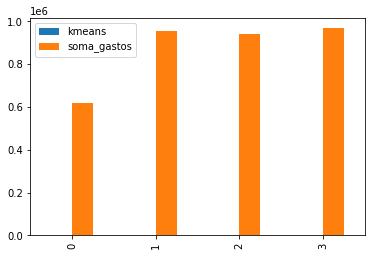

In [36]:
cols = dados2.columns[dados2.columns != 'kmeans']
dados2['soma_gastos'] = dados2[cols].sum(axis=1)
dados2.groupby('kmeans', as_index=False).soma_gastos.mean().plot(kind='bar')

## b) Alternativas
Use outro algoritmo de clustering e faça uma nova classificação dos e das parlamentares. Compare com a anterior para examinar as diferenças.

In [45]:
hierarq = AgglomerativeClustering()
hierarq.fit(dados2)
dados2 = dados2.assign(hierarq = hierarq.labels_)

<AxesSubplot: >

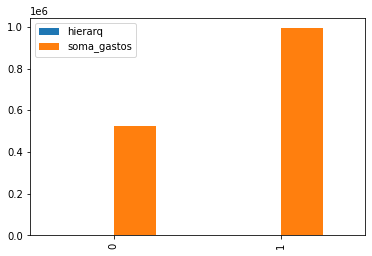

In [50]:
dados2.groupby('hierarq', as_index=False).soma_gastos.mean().plot(kind='bar')